In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns # seaborn là thư viện được xây trên matplotlib, giúp việc visualization đỡ khổ hơn
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [30]:
data_df = pd.read_csv('train_val_data.csv', index_col=False)
data_df.head()

,ChipsetBrand,CardDescription,NumberOfUSB2.0Ports,NumberOfUSB3.0Ports,BrandName,OperatingSystem,ProcessorBrand,ProcessorCount,HardDriveInterface,HardwarePlatform,...,HardDrive_capacity_pcs,ItemWeight_pcs,ItemDimensions_L_pcs,ItemDimensions_W_pcs,ItemDimensions_H_pcs,AverageBatteryLife_pcs,Batteries_pcs,GraphicsCardRamSize_pcs,FlashMemorySize_pcs,Processor_ghz_pcs
0,nvidia,dedicated,4.0,8.0,asus,windows,intel,8.0,solid state,pc,...,1000.0,24.30,18.0,15.7,7.00,NaN,1 Lithium Polymer batteries required,6.0,512.0,NaN
1,intel,dedicated,NaN,NaN,dell,windows,intel,6.0,serial ata,pc,...,256.0,7.28,15.9,11.6,7.28,NaN,1 Lithium Polymer batteries required,NaN,NaN,2.6
2,intel,NaN,1.0,NaN,asus,windows,intel,2.0,solid state,pc,...,128.0,3.55,13.2,8.9,0.70,NaN,1 Lithium ion batteries required,NaN,NaN,1.1
3,NaN,integrated,1.0,NaN,hp,windows,intel,1.0,serial ata,pc,...,500.0,7.67,15.0,10.1,1.20,NaN,NaN,NaN,NaN,2.7
4,amd,NaN,NaN,NaN,lenovo,windows,amd,2.0,serial ata-600,pc,...,1000.0,5.95,12.8,9.2,0.70,5.0,NaN,NaN,NaN,3.7


In [31]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2488 entries, 0 to 2487
Data columns (total 26 columns):
ChipsetBrand                      1988 non-null object
CardDescription                   2007 non-null object
NumberOfUSB2.0Ports               645 non-null float64
NumberOfUSB3.0Ports               347 non-null float64
BrandName                         2481 non-null object
OperatingSystem                   2482 non-null object
ProcessorBrand                    2487 non-null object
ProcessorCount                    2465 non-null float64
HardDriveInterface                2380 non-null object
HardwarePlatform                  2488 non-null object
Price_pcs                         2488 non-null float64
ScreenSize_pcs                    2248 non-null float64
MaxScreenResolution_width_pcs     1884 non-null float64
MaxScreenResolution_height_pcs    1884 non-null float64
RAM_capacity_pcs                  2485 non-null float64
RAM_type_pcs                      2338 non-null object
HardDri

# Split Data

In [32]:
y_sr = data_df['Price_pcs']
X_df = data_df.drop('Price_pcs', axis=1)

In [33]:
train_X_df, val_X_df, train_y_sr, val_y_sr = train_test_split(X_df, y_sr, test_size=0.15, random_state=0)

In [34]:
train_X_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2114 entries, 2201 to 1653
Data columns (total 25 columns):
ChipsetBrand                      1686 non-null object
CardDescription                   1697 non-null object
NumberOfUSB2.0Ports               551 non-null float64
NumberOfUSB3.0Ports               295 non-null float64
BrandName                         2108 non-null object
OperatingSystem                   2108 non-null object
ProcessorBrand                    2113 non-null object
ProcessorCount                    2093 non-null float64
HardDriveInterface                2021 non-null object
HardwarePlatform                  2114 non-null object
ScreenSize_pcs                    1915 non-null float64
MaxScreenResolution_width_pcs     1605 non-null float64
MaxScreenResolution_height_pcs    1605 non-null float64
RAM_capacity_pcs                  2111 non-null float64
RAM_type_pcs                      1989 non-null object
HardDrive_capacity_pcs            2114 non-null float64
Item

# Transform data

In [36]:
class ColAdderDropper(BaseEstimator, TransformerMixin):
    def __init__(self, num_top_chipsetbrand=3, num_top_carddescription=2, num_top_operating=7, num_top_brandname=30, 
                 num_top_processorbrand=10): #, num_top_hardware=4,:
        self.num_top_chipsetbrand = num_top_chipsetbrand
        self.num_top_carddescription = num_top_carddescription
        self.num_top_brandname = num_top_brandname
        self.num_top_operating = num_top_operating
        self.num_top_processorbrand = num_top_processorbrand
#         self.num_top_hardware = num_top_hardware
    def fit(self, X_df, y=None):
        self.chipsetbrand_count = X_df['ChipsetBrand'].value_counts()
        chipbrand = list(self.chipsetbrand_count.index)
        self.top_chipsetbrand_ = chipbrand[:max(1, min(self.num_top_chipsetbrand, len(chipbrand)))]
        
        self.carddescription_count = X_df['CardDescription'].value_counts()
        carddes = list(self.carddescription_count.index)
        self.top_carddescription_ = carddes[:max(1, min(self.num_top_carddescription, len(carddes)))]
        
        self.operating_count = X_df['OperatingSystem'].value_counts()
        opers = list(self.operating_count.index)
        self.top_operating_ = opers[:max(1, min(self.num_top_operating, len(opers)))]
        
        self.brandname_count = X_df['BrandName'].value_counts()
        brandname_ = list(self.brandname_count.index)
        self.top_brandname_ = brandname_[:max(1, min(self.num_top_operating, len(brandname_)))]
        
        self.processorbrand_count = X_df['ProcessorBrand'].value_counts()
        processbrand = list(self.processorbrand_count.index)
        self.top_processorbrand_ = processbrand[:max(1, min(self.num_top_processorbrand, len(processbrand)))]
        
#         self.hardware_count = X_df['HardwarePlatform'].value_counts()
#         hardware = list(self.hardware_count.index)
#         self.top_hardware_ = hardware[:max(1, min(self.num_top_hardware, len(hardware)))]
        
        return self
    def transform(self, X_df, y=None):
        transformed_X_df = X_df.copy()
        
        transformed_X_df.loc[~transformed_X_df.ChipsetBrand.isin(self.top_chipsetbrand_) & ~transformed_X_df.ChipsetBrand.isna(), 'ChipsetBrand'] = 'others'
        transformed_X_df.loc[~transformed_X_df.CardDescription.isin(self.top_carddescription_) & ~transformed_X_df.CardDescription.isna(), 'CardDescription'] = 'integrated'
        transformed_X_df.loc[~transformed_X_df.BrandName.isin(self.top_brandname_) & ~transformed_X_df.BrandName.isna(), 'BrandName'] = 'others'
        transformed_X_df.loc[~transformed_X_df.OperatingSystem.isin(self.top_operating_) & ~transformed_X_df.OperatingSystem.isna(), 'OperatingSystem'] = 'others'
        transformed_X_df.loc[~transformed_X_df.ProcessorBrand.isin(self.top_processorbrand_) & ~transformed_X_df.ProcessorBrand.isna(), 'ProcessorBrand'] = 'others'
#         transformed_X_df.loc[~transformed_X_df.HardwarePlatform.isin(self.top_hardware_) & ~transformed_X_df.HardwarePlatform.isna(), 'HardwarePlatform'] = 'others'

        transformed_X_df = transformed_X_df.drop(['NumberOfUSB2.0Ports', 'NumberOfUSB3.0Ports', 'HardDriveInterface', 'HardwarePlatform',
                                                 'AverageBatteryLife_pcs', 'RAM_type_pcs', 'GraphicsCardRamSize_pcs',
                                                 'FlashMemorySize_pcs', 'Batteries_pcs'], axis=1)
        
        return transformed_X_df

In [8]:
# data_df = pd.read_csv('train_val_data.csv', index_col=False)
# train_X_df, val_X_df, train_y_sr, val_y_sr = train_test_split(X_df, y_sr, test_size=0.15, random_state=0)
# col_adderdropper = ColAdderDropper()
# train_X_df = col_adderdropper.fit_transform(train_X_df)
# val_X_df = col_adderdropper.fit_transform(val_X_df)
# train_X_df.isna().values.sum()

In [37]:
class FillNA(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.fillna_values = {}
    def fit(self, X_df, y=None):
        self.fillna_values['ProcessorCount'] = X_df['ProcessorCount'].mean()
        self.fillna_values['ScreenSize_pcs'] = X_df['ScreenSize_pcs'].mean()
        self.fillna_values['MaxScreenResolution_width_pcs'] = X_df['MaxScreenResolution_width_pcs'].mean()
        self.fillna_values['MaxScreenResolution_height_pcs'] = X_df['MaxScreenResolution_height_pcs'].mean()
        self.fillna_values['HardDrive_capacity_pcs'] = X_df['HardDrive_capacity_pcs'].mean()
        self.fillna_values['ItemDimensions_L_pcs'] = X_df['ItemDimensions_L_pcs'].mean()
        self.fillna_values['ItemDimensions_W_pcs'] = X_df['ItemDimensions_W_pcs'].mean()
        self.fillna_values['ItemDimensions_H_pcs'] = X_df['ItemDimensions_H_pcs'].mean()
#         self.fillna_values['AverageBatteryLife_pcs'] = X_df['AverageBatteryLife_pcs'].mean()
#         self.fillna_values['GraphicsCardRamSize_pcs'] = 0.0 #X_df['GraphicsCardRamSize_pcs'].mean()
#         self.fillna_values['FlashMemorySize_pcs'] = 0.0 #X_df['FlashMemorySize_pcs'].mean()
        self.fillna_values['Processor_ghz_pcs'] = X_df['Processor_ghz_pcs'].mean()
        self.fillna_values['RAM_capacity_pcs'] = X_df['RAM_capacity_pcs'].mean()
        self.fillna_values['ItemWeight_pcs'] = X_df['ItemWeight_pcs'].mean()
        
        self.fillna_values['ChipsetBrand'] = X_df['ChipsetBrand'].mode()[0]
        self.fillna_values['CardDescription'] = X_df['CardDescription'].mode()[0]
        self.fillna_values['BrandName'] = X_df['BrandName'].mode()[0]
        self.fillna_values['OperatingSystem'] = X_df['OperatingSystem'].mode()[0]
        self.fillna_values['ProcessorBrand'] = X_df['ProcessorBrand'].mode()[0]
#         self.fillna_values['HardDriveInterface'] = X_df['HardDriveInterface'].mode()[0]
#         self.fillna_values['HardwarePlatform'] = X_df['HardwarePlatform'].mode()[0]
#         self.fillna_values['RAM_type_pcs'] = X_df['RAM_type_pcs'].mode()[0]
#         self.fillna_values['Batteries_pcs'] = X_df['Batteries_pcs'].mode()[0]
            
        return self
    
    def transform(self, X_df, y=None):
        transformed_X_df = X_df.copy()
        
        transformed_X_df['ProcessorCount'].fillna(value=self.fillna_values['ProcessorCount'], inplace=True)
        transformed_X_df['ScreenSize_pcs'].fillna(value=self.fillna_values['ScreenSize_pcs'], inplace=True)
        transformed_X_df['MaxScreenResolution_width_pcs'].fillna(value=self.fillna_values['MaxScreenResolution_width_pcs'], inplace=True)
        transformed_X_df['MaxScreenResolution_height_pcs'].fillna(value=self.fillna_values['MaxScreenResolution_height_pcs'], inplace=True)
        transformed_X_df['HardDrive_capacity_pcs'].fillna(value=self.fillna_values['HardDrive_capacity_pcs'], inplace=True)
        transformed_X_df['ItemDimensions_L_pcs'].fillna(value=self.fillna_values['ItemDimensions_L_pcs'], inplace=True)
        transformed_X_df['ItemDimensions_W_pcs'].fillna(value=self.fillna_values['ItemDimensions_W_pcs'], inplace=True)
        transformed_X_df['ItemDimensions_H_pcs'].fillna(value=self.fillna_values['ItemDimensions_H_pcs'], inplace=True)
#         transformed_X_df['AverageBatteryLife_pcs'].fillna(value=self.fillna_values['AverageBatteryLife_pcs'], inplace=True)
#         transformed_X_df['GraphicsCardRamSize_pcs'].fillna(value=self.fillna_values['GraphicsCardRamSize_pcs'], inplace=True)
#         transformed_X_df['FlashMemorySize_pcs'].fillna(value=self.fillna_values['FlashMemorySize_pcs'], inplace=True)
        transformed_X_df['Processor_ghz_pcs'].fillna(value=self.fillna_values['Processor_ghz_pcs'], inplace=True)
        transformed_X_df['RAM_capacity_pcs'].fillna(value=self.fillna_values['RAM_capacity_pcs'], inplace=True)
        transformed_X_df['ItemWeight_pcs'].fillna(value=self.fillna_values['ItemWeight_pcs'], inplace=True)
        
        transformed_X_df['ChipsetBrand'].fillna(value=self.fillna_values['ChipsetBrand'], inplace=True)
        transformed_X_df['CardDescription'].fillna(value=self.fillna_values['CardDescription'], inplace=True)
        transformed_X_df['BrandName'].fillna(value=self.fillna_values['BrandName'], inplace=True)
        transformed_X_df['OperatingSystem'].fillna(value=self.fillna_values['OperatingSystem'], inplace=True)
        transformed_X_df['ProcessorBrand'].fillna(value=self.fillna_values['ProcessorBrand'], inplace=True)
#         transformed_X_df['HardDriveInterface'].fillna(value=self.fillna_values['HardDriveInterface'], inplace=True)
#         transformed_X_df['HardwarePlatform'].fillna(value=self.fillna_values['HardwarePlatform'], inplace=True)
#         transformed_X_df['RAM_type_pcs'].fillna(value=self.fillna_values['RAM_type_pcs'], inplace=True)
#         transformed_X_df['Batteries_pcs'].fillna(value=self.fillna_values['Batteries_pcs'], inplace=True)
        
        return transformed_X_df

In [10]:
# fillNa = FillNA()
# fillNa.fit(train_X_df)
# train_X_df = fillNa.transform(train_X_df)
# train_X_df.info()

In [11]:
# val_X_df = fillNa.transform(val_X_df)
# val_X_df.info()

In [12]:
# train_X_df['BrandName'].isna().values.sum()

In [13]:
# val_X_df['BrandName'].value_counts()

# Full Pipeline - Train

In [38]:
numeric_cols = ['ScreenSize_pcs', 'ProcessorCount', 'MaxScreenResolution_width_pcs', 'MaxScreenResolution_height_pcs', 'RAM_capacity_pcs', 
                 'ItemWeight_pcs', 'Processor_ghz_pcs',
                'ItemDimensions_L_pcs', 'ItemDimensions_W_pcs', 'ItemDimensions_H_pcs']
category_cols = ['ChipsetBrand', 'CardDescription', 'BrandName', 'OperatingSystem', 'ProcessorBrand']

numeric_imputer = Pipeline([('imputer', SimpleImputer(strategy='mean'))])
category_imputer = Pipeline([('one_hot_vector', OneHotEncoder(handle_unknown='ignore'))])

transform_cols = ColumnTransformer([('category_imputer', category_imputer, category_cols)])
reprocess_pipeline = Pipeline([('coladderdropper', ColAdderDropper()), ('fill_na', FillNA()), ('transform_cols', transform_cols), ('std_scaler', StandardScaler(with_mean=False))])

# Logistic regression

In [39]:
logistic_regression = LogisticRegression(solver='lbfgs', max_iter=500, verbose=0, n_jobs=4, random_state=0)
full_pipeline = Pipeline([('reprocess_data', reprocess_pipeline), ('logistic_regression', logistic_regression)])

max_iter = [50, 100, 200, 300, 500, 1000]
for iter_ in max_iter:
    full_pipeline.set_params(logistic_regression__max_iter=iter_)
    full_pipeline.fit(train_X_df, train_y_sr)
    print('MaxIter: %f - Train acc: %f - Val acc: %f' %(iter_, full_pipeline.score(train_X_df, train_y_sr), full_pipeline.score(val_X_df, val_y_sr)))

MaxIter: 50.000000 - Train acc: 0.554399 - Val acc: 0.513369
MaxIter: 100.000000 - Train acc: 0.553453 - Val acc: 0.516043
MaxIter: 200.000000 - Train acc: 0.553453 - Val acc: 0.516043
MaxIter: 300.000000 - Train acc: 0.553453 - Val acc: 0.516043
MaxIter: 500.000000 - Train acc: 0.553453 - Val acc: 0.516043
MaxIter: 1000.000000 - Train acc: 0.553453 - Val acc: 0.516043


# MLPClassifier

In [28]:
mlp_classifier = MLPClassifier((30, 40, 20,), 'tanh', 'lbfgs', max_iter=200, random_state=0, verbose=False)
full_pipeline = Pipeline([('reprocess_data', reprocess_pipeline), ('mlp_classifier', mlp_classifier)])

alphas = [0.1, 1, 10]
max_iter = [200, 500, 1000]
for alpha in alphas:
    for iter_ in max_iter:
        full_pipeline.set_params(mlp_classifier__alpha=alpha, mlp_classifier__max_iter=iter_)
        full_pipeline.fit(train_X_df, train_y_sr)
        print('Alpha: %f - MaxIter: %f - Train acc: %f - Val acc: %f' %(alpha, iter_, full_pipeline.score(train_X_df, train_y_sr), full_pipeline.score(val_X_df, val_y_sr)))

c:\users\huynhnhut\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Alpha: 0.100000 - MaxIter: 200.000000 - Train acc: 0.572375 - Val acc: 0.545455


c:\users\huynhnhut\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Alpha: 0.100000 - MaxIter: 500.000000 - Train acc: 0.572848 - Val acc: 0.550802


c:\users\huynhnhut\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Alpha: 0.100000 - MaxIter: 1000.000000 - Train acc: 0.572848 - Val acc: 0.545455


c:\users\huynhnhut\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Alpha: 1.000000 - MaxIter: 200.000000 - Train acc: 0.572848 - Val acc: 0.550802


c:\users\huynhnhut\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Alpha: 1.000000 - MaxIter: 500.000000 - Train acc: 0.572848 - Val acc: 0.545455


c:\users\huynhnhut\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Alpha: 1.000000 - MaxIter: 1000.000000 - Train acc: 0.572848 - Val acc: 0.545455


c:\users\huynhnhut\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Alpha: 10.000000 - MaxIter: 200.000000 - Train acc: 0.562441 - Val acc: 0.548128


c:\users\huynhnhut\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Alpha: 10.000000 - MaxIter: 500.000000 - Train acc: 0.561968 - Val acc: 0.548128
Alpha: 10.000000 - MaxIter: 1000.000000 - Train acc: 0.562914 - Val acc: 0.550802


c:\users\huynhnhut\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


# SVM

In [17]:
svm_ = svm.SVC(verbose=False, random_state=0, max_iter=100)
full_pipeline = Pipeline([('reprocess_data', reprocess_pipeline), ('svm', svm_)])

max_iter = [300, 500, 1000, 2000, 4000]
for iter_ in max_iter:
    full_pipeline.set_params(svm__max_iter=iter_)
    full_pipeline.fit(train_X_df, train_y_sr)
    print('MaxIter: %f - Train acc: %f - Val acc: %f' %(iter_, full_pipeline.score(train_X_df, train_y_sr), full_pipeline.score(val_X_df, val_y_sr)))

c:\users\huynhnhut\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


MaxIter: 300.000000 - Train acc: 0.541627 - Val acc: 0.505348


c:\users\huynhnhut\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


MaxIter: 500.000000 - Train acc: 0.556764 - Val acc: 0.524064
MaxIter: 1000.000000 - Train acc: 0.555345 - Val acc: 0.516043
MaxIter: 2000.000000 - Train acc: 0.555345 - Val acc: 0.516043
MaxIter: 4000.000000 - Train acc: 0.555345 - Val acc: 0.516043


# Randomforest

In [18]:
random_forest = RandomForestClassifier(n_estimators=200, verbose=0, n_jobs=4, random_state=0, oob_score=True)
full_pipeline = Pipeline([('reprocess_data', reprocess_pipeline), ('random_forest', random_forest)])

n_estimators = [100, 200, 300]
for n_es_ in n_estimators:
    full_pipeline.set_params(random_forest__n_estimators=n_es_)
    full_pipeline.fit(train_X_df, train_y_sr)
    print('n_estimator: %d - Train acc: %f - Val acc: %f' %(n_es_, full_pipeline.score(train_X_df, train_y_sr), full_pipeline.score(val_X_df, val_y_sr)))

n_estimator: 100 - Train acc: 0.572848 - Val acc: 0.545455
n_estimator: 200 - Train acc: 0.572848 - Val acc: 0.548128
n_estimator: 300 - Train acc: 0.572848 - Val acc: 0.545455


# Test

In [19]:
test_data_df = pd.read_csv('test_data.csv', index_col=False)

In [20]:
test_y_sr = test_data_df['Price_pcs']
test_X_df = test_data_df.drop('Price_pcs', axis=1)

In [26]:
test_model = LogisticRegression(solver='lbfgs', max_iter=500, verbose=0, n_jobs=4, random_state=0)
full_pipeline = Pipeline([('reprocess_data', reprocess_pipeline), ('test_model', test_model)])

fits = full_pipeline.fit(train_X_df, train_y_sr)
score = fits.score(test_X_df, test_y_sr)
score

0.5018050541516246

[[17 66  0  0]
 [13 99  7  0]
 [ 2 35 23  0]
 [ 0  5 10  0]]


Text(0.5, 1, 'Accuracy Score: 0.5018050541516246')

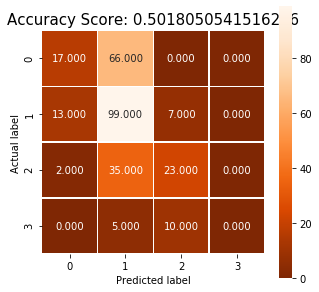

In [22]:
y_predicted = full_pipeline.predict(test_X_df)
cm = metrics.confusion_matrix(test_y_sr, y_predicted)
print(cm)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Oranges_r');
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15)